Enter your RunPod API key:  ········


Sending request to start the job (no LoRAs)...
Job successfully started with ID: 9cb73f6f-da4d-418c-b5f6-96907ae06c9b-u1
Polling for job status... (attempt 1)
Polling for job status... (attempt 2)
Polling for job status... (attempt 3)
Polling for job status... (attempt 4)
Polling for job status... (attempt 5)
Polling for job status... (attempt 6)
Polling for job status... (attempt 7)
Polling for job status... (attempt 8)
Polling for job status... (attempt 9)
Polling for job status... (attempt 10)
Polling for job status... (attempt 11)
Polling for job status... (attempt 12)
Polling for job status... (attempt 13)
Polling for job status... (attempt 14)
Polling for job status... (attempt 15)
Polling for job status... (attempt 16)
Polling for job status... (attempt 17)
Polling for job status... (attempt 18)
Polling for job status... (attempt 19)
Polling for job status... (attempt 20)
Polling for job status... (attempt 21)
Polling for job status... (attempt 22)
Polling for job status... (att

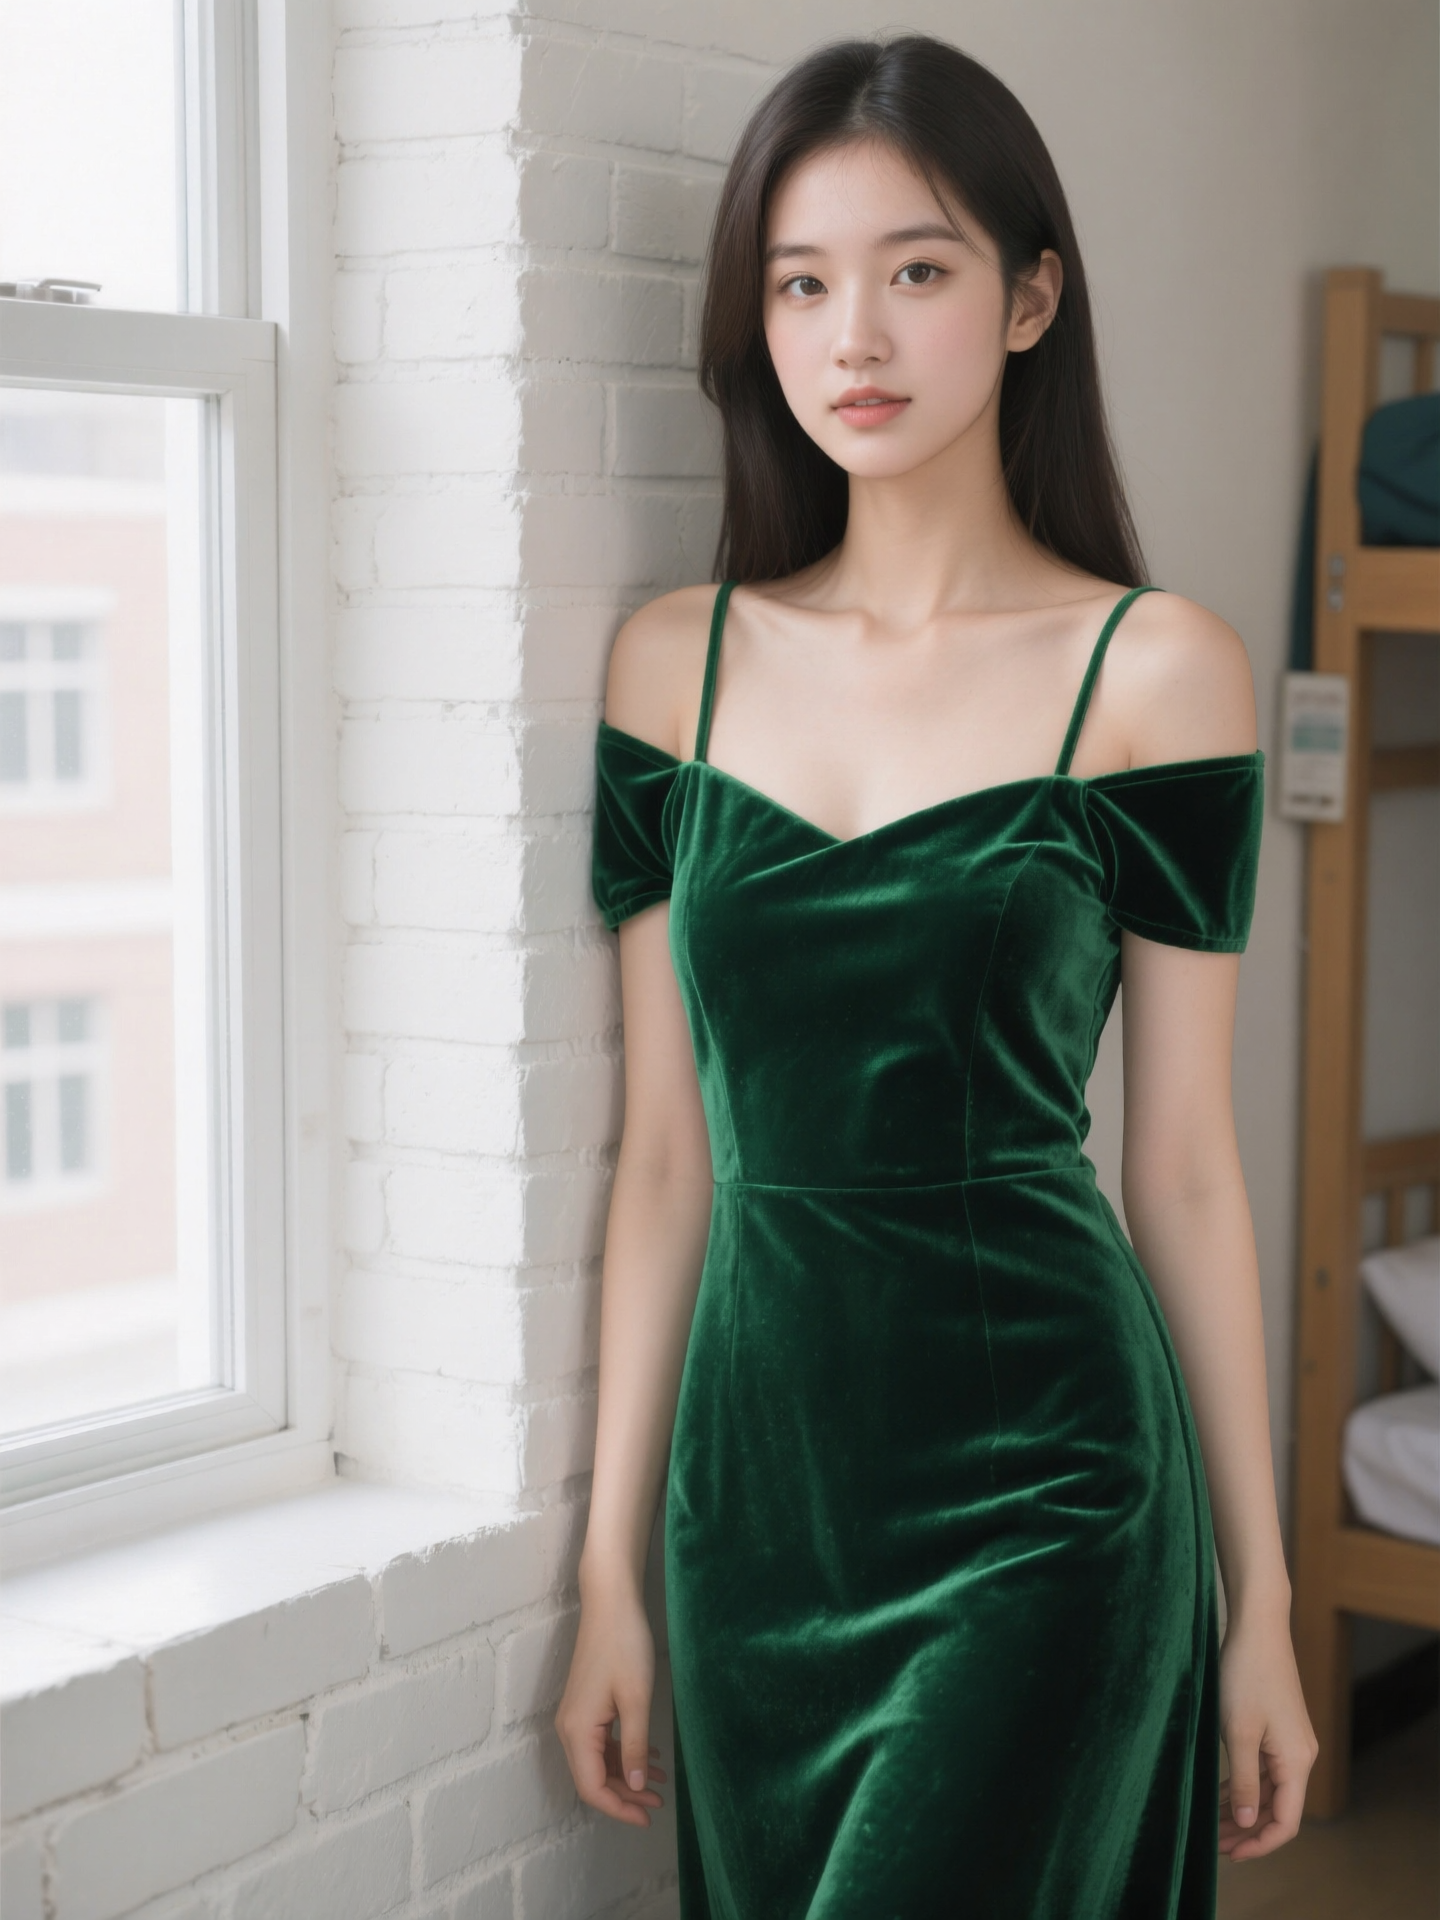

✓ Image displayed above



In [14]:
import requests
import base64
import json
import time
from PIL import Image
from io import BytesIO
from dotenv import load_dotenv 
import os

# --- 1. Configuration ---
load_dotenv()
api_key = os.getenv("RUNPOD_API_KEY")

if not api_key:
    from getpass import getpass
    api_key = getpass("Enter your RunPod API key: ")

endpoint_id = "a48mrbdsbzg35n"

# --- 2. Define the API URLs ---
run_url = f"https://api.runpod.ai/v2/{endpoint_id}/run"
status_url_template = f"https://api.runpod.ai/v2/{endpoint_id}/status/"

# --- 3. Simplified Workflow (No LoRAs) ---
workflow_payload = {
    "input": {
        "workflow": {
            "6": {
                "inputs": {
                    "text": "1girl, candid photo of woman in emerald green velvet dress, off-shoulder straps, standing against white brick wall in university dorm, soft window light, relaxed pose, photorealistic 8k.",
                    "clip": ["99", 0]
                },
                "class_type": "CLIPTextEncode",
                "_meta": {"title": "CLIP Text Encode (Positive Prompt)"}
            },
            "7": {
                "inputs": {
                    "text": "cinematic, glossy finish, shallow depth of field, cinematic bokeh, uncanny anatomy, frame-perfect symmetry, blurred background, fat, low resolution",
                    "clip": ["99", 0]
                },
                "class_type": "CLIPTextEncode",
                "_meta": {"title": "CLIP Text Encode (Negative Prompt)"}
            },
            "8": {
                "inputs": {
                    "samples": ["75", 0],
                    "vae": ["39", 0]
                },
                "class_type": "VAEDecode",
                "_meta": {"title": "VAE Decode"}
            },
            "39": {
                "inputs": {
                    "vae_name": "qwen_image_vae.safetensors"
                },
                "class_type": "VAELoader",
                "_meta": {"title": "Load VAE"}
            },
            "60": {
                "inputs": {
                    "filename_prefix": "test_qwen",
                    "images": ["8", 0]
                },
                "class_type": "SaveImage",
                "_meta": {"title": "Save Image"}
            },
            "66": {
                "inputs": {
                    "shift": 3.1,
                    "model": ["96", 0]
                },
                "class_type": "ModelSamplingAuraFlow",
                "_meta": {"title": "ModelSamplingAuraFlow"}
            },
            "75": {
                "inputs": {
                    "eta": 0.5,
                    "sampler_name": "exponential/res_2s",
                    "scheduler": "beta57",
                    "steps": 50,
                    "steps_to_run": -1,
                    "denoise": 1,
                    "cfg": 2.5,
                    "seed": ["94", 0],
                    "sampler_mode": "standard",
                    "bongmath": True,
                    "model": ["66", 0],
                    "positive": ["6", 0],
                    "negative": ["7", 0],
                    "latent_image": ["95", 0]
                },
                "class_type": "ClownsharKSampler_Beta",
                "_meta": {"title": "ClownsharKSampler"}
            },
            "94": {
                "inputs": {
                    "seed": 856972950558738
                },
                "class_type": "Seed Generator",
                "_meta": {"title": "Seed Generator"}
            },
            "95": {
                "inputs": {
                    "width": 1440,
                    "height": 1920,
                    "batch_size": 1
                },
                "class_type": "EmptyLatentImage",
                "_meta": {"title": "Empty Latent Image"}
            },
            "96": {
                "inputs": {
                    "unet_name": "qwen_image_fp8_e4m3fn.safetensors",
                    "weight_dtype": "default"
                },
                "class_type": "UNETLoader",
                "_meta": {"title": "Load Diffusion Model"}
            },
            "99": {
                "inputs": {
                    "clip_name": "qwen_2.5_vl_7b.safetensors",
                    "type": "qwen_image",
                    "device": "default"
                },
                "class_type": "CLIPLoader",
                "_meta": {"title": "Load CLIP"}
            }
        }
    }
}

# --- 4. Send the Initial API Request ---
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

print("Sending request to start the job (no LoRAs)...")
response = requests.post(run_url, headers=headers, json=workflow_payload)

if response.status_code == 200:
    response_data = response.json()
    job_id = response_data.get('id')
    
    if not job_id:
        print("Error: API response did not include a job ID.")
        print("Full response:", json.dumps(response_data, indent=2))
    else:
        print(f"Job successfully started with ID: {job_id}")

        # --- 5. Poll for the Job Status ---
        status_url = status_url_template + job_id
        poll_count = 0
        while True:
            poll_count += 1
            print(f"Polling for job status... (attempt {poll_count})")
            status_response = requests.get(status_url, headers=headers)
            status_data = status_response.json()
            job_status = status_data.get('status')

            if job_status == 'COMPLETED':
                print("Job completed successfully!")
                
                # --- 6. Process the Final Output ---
                try:
                    output_image_data = status_data['output']['images'][0]
                    image_base64 = output_image_data['data'] 
                    filename = output_image_data['filename']

                    image_bytes = base64.b64decode(image_base64)
                    image = Image.open(BytesIO(image_bytes))
                    
                    # Save the image
                    image.save(filename)
                    print(f"\n✓ Image successfully generated and saved as '{filename}'")
                    
                    # Display the image (works in Jupyter notebooks)
                    try:
                        from IPython.display import display
                        display(image)
                        print("Image displayed above\n")
                    except ImportError:
                        print("(Not in Jupyter - image saved but not displayed)\n")
                        # For non-Jupyter environments, try to show with PIL
                        try:
                            image.show()
                        except:
                            pass

                except (KeyError, IndexError, TypeError) as e:
                    print(f"\n✗ Error: Could not parse image data: {e}\n")
                    print("Full response:", json.dumps(status_data, indent=2))
                
                break

            elif job_status in ['IN_QUEUE', 'IN_PROGRESS']:
                time.sleep(5)
            elif job_status == 'FAILED':
                print(f"\n✗ Job execution failed.")
                print("Error details:", status_data.get('error', 'No error message provided'))
                if 'output' in status_data:
                    print("Output:", status_data['output'])
                break
            else:
                print(f"\n✗ Unexpected job status: {job_status}")
                print("Full response:", json.dumps(status_data, indent=2))
                break

else:
    print(f"✗ Error: Initial API request failed with status code {response.status_code}")
    print("Response:", response.text)